In [12]:
# all the libs
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torchvision import datasets, transforms, models

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Data Pre-Processing
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Set the root directory where "RealWaste" is located
data_dir = '/content/drive/MyDrive/Colab Notebooks/project/realwaste-main/RealWaste'

# Create the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=None)

# Define the transformation pipeline
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class SubsetWithTransform(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return self.transform(x), y
    def __len__(self):
        return len(self.subset)

# No transform in ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=None)

# calculate the sizes
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% train
test_size = total_size - train_size

# Split
db_train, db_test = random_split(dataset, [train_size, test_size])

# Wrap with transforms
db_train = SubsetWithTransform(db_train, transform_train)
db_test = SubsetWithTransform(db_test, transform_test)

# Define the data loaders
loader_train = DataLoader(db_train, batch_size=32, shuffle=True, drop_last=True)
loader_test = DataLoader(db_test, batch_size=32, shuffle=False)

In [15]:
# training utils
from torch import nn
import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def fit_one_epoch(model, opt, loader):
    model.train(True)
    loss = nn.CrossEntropyLoss()
    losses, accuracies = [], []
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        l = loss(pred, labels)
        acc = (pred.argmax(1) == labels).float().mean()

        l.backward()
        opt.step()
        opt.zero_grad()

        losses.append(l.detach().item())
        accuracies.append(acc.detach().item())
    return np.mean(losses), np.mean(accuracies)

@torch.no_grad()
def eval(model, loader):
    model.train(False)
    loss = nn.CrossEntropyLoss()
    accuracies, losses = [], []
    for images, labels in tqdm.tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        pred = model(images)
        acc = (pred.argmax(1) == labels).float().mean()
        l = loss(pred, labels)

        accuracies.append(acc.detach().item())
        losses.append(l.detach().item())
    return np.mean(losses), np.mean(accuracies)


def fit(model, loader_train, loader_val, epochs=50, opt=None):
    assert opt is not None
    hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc = [], [], [], []
    for epoch in range(epochs):
        val_l, val_acc = eval(model, loader_val)
        tr_l, tr_acc = fit_one_epoch(model, opt, loader_train)

        print(f"Finished epoch {epoch} of {epochs}: Train Loss = {tr_l:.3f}  Val Loss = {val_l:.3f}   Train Acc = {tr_acc:.3f}   Val Acc = {val_acc:.3f}", flush=True)
        hist_tr_loss.append(tr_l)
        hist_val_loss.append(val_l)
        hist_tr_acc.append(tr_acc)
        hist_val_acc.append(val_acc)
    return hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc

def plot_training_history(hist_tr_loss, hist_val_loss, hist_tr_acc, hist_val_acc):
    plt.subplot(1, 2, 1)
    plt.plot(hist_tr_acc, label='train accuracy')
    plt.plot(hist_val_acc, label='val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(hist_tr_loss, label='train loss')
    plt.plot(hist_val_loss, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In [16]:
# Train
def train(model, loader_train, loader_test, epochs=5, lr=0.01):

  # Define the optimizer
  opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

  # Fit the model to our data
  hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc = fit(model, loader_train, loader_test, epochs=epochs, opt=opt)

  # eval
  l, acc = eval(model, loader_test)
  plot_training_history(hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc)
  print(f'Test accuracy: {acc*100:.2f}%')
  print(f'Test loss: {l:.3f}')

In [17]:
# Fine tuning
def fine_tuning(model, loader_train, loader_test, epochs=2, lr=0.001):

    # Unfreeze the entire model for fine-tuning
  for p in model.parameters():
      p.requires_grad = True

  # Define optimizer
  params = [p for p in model.parameters() if p.requires_grad]
  opt = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)

  # Training
  hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc = fit(model, loader_train, loader_test, epochs=epochs, opt=opt)

  # Testing
  loader_test = DataLoader(db_test, batch_size=64, shuffle=False)
  l, acc = eval(model, loader_test)
  plot_training_history(hist_tr_loss, hist_test_loss, hist_tr_acc, hist_test_acc)
  print(f'Test accuracy: {acc*100:.2f}%')
  print(f'Test loss: {l:.3f}')

In [27]:
import seaborn as sns

@torch.no_grad()
def evaluate_metrics(model, loader):
    model.eval()
    y_pred = []
    y_true = []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

    # Compute metrics
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, labels=labels, average=None)
    recall = recall_score(y_true, y_pred, labels=labels, average=None)
    f1 = f1_score(y_true, y_pred, labels=labels, average=None)

    # Confusion Matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Accuracy: {acc:.4f}")
    for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
        print(f"Class {i}: Precision: {p:.4f}, Recall: {r:.4f}, F1 Score: {f:.4f}")


    # Macro-averaged scores
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    print(f"Macro-Precision: {macro_precision:.4f}, Macro-Recall: {macro_recall:.4f}, Macro-F1: {macro_f1:.4f}")

In [24]:
# train-fine-tune-pipeline
def pipeline(model):
  global db_train, db_test, loader_train, loader_test

  # Define the model for 9-class classification
  num_features = model.classifier.in_features
  model.classifier = nn.Linear(num_features, 9)

  # Move entire model to device
  model = model.to(device)

  # Freeze feature extractor
  for param in model.features.parameters():
      param.requires_grad = False

  # Test the model with one batch to confirm it works
  image_batch, label_batch = db_train[0]
  feature_batch = model(image_batch[None].to(device))

  # Train the model
  train(model, loader_train, loader_test, epochs=8, lr = 0.01)

  # fine tune
  fine_tuning(model, loader_train, loader_test, epochs=10, lr=0.001)

  # evaluate the model
  evaluate_metrics(model, loader_test)

  return model

100%|██████████| 118/118 [26:36<00:00, 13.53s/it]

Finished epoch 0 of 8: Train Loss = 1.069  Val Loss = 2.236   Train Acc = 0.632   Val Acc = 0.096



100%|██████████| 118/118 [19:32<00:00,  9.93s/it]

Finished epoch 1 of 8: Train Loss = 0.601  Val Loss = 0.652   Train Acc = 0.786   Val Acc = 0.779



100%|██████████| 118/118 [20:26<00:00, 10.39s/it]

Finished epoch 2 of 8: Train Loss = 0.512  Val Loss = 0.614   Train Acc = 0.814   Val Acc = 0.793



100%|██████████| 118/118 [20:19<00:00, 10.33s/it]

Finished epoch 3 of 8: Train Loss = 0.474  Val Loss = 0.604   Train Acc = 0.835   Val Acc = 0.796



100%|██████████| 118/118 [20:13<00:00, 10.28s/it]

Finished epoch 4 of 8: Train Loss = 0.427  Val Loss = 0.663   Train Acc = 0.849   Val Acc = 0.783



100%|██████████| 118/118 [20:14<00:00, 10.29s/it]

Finished epoch 5 of 8: Train Loss = 0.430  Val Loss = 0.744   Train Acc = 0.848   Val Acc = 0.776



100%|██████████| 118/118 [20:12<00:00, 10.27s/it]

Finished epoch 6 of 8: Train Loss = 0.373  Val Loss = 0.594   Train Acc = 0.868   Val Acc = 0.799



100%|██████████| 118/118 [20:20<00:00, 10.34s/it]

Finished epoch 7 of 8: Train Loss = 0.362  Val Loss = 0.566   Train Acc = 0.872   Val Acc = 0.810



100%|██████████| 30/30 [04:19<00:00,  8.66s/it]


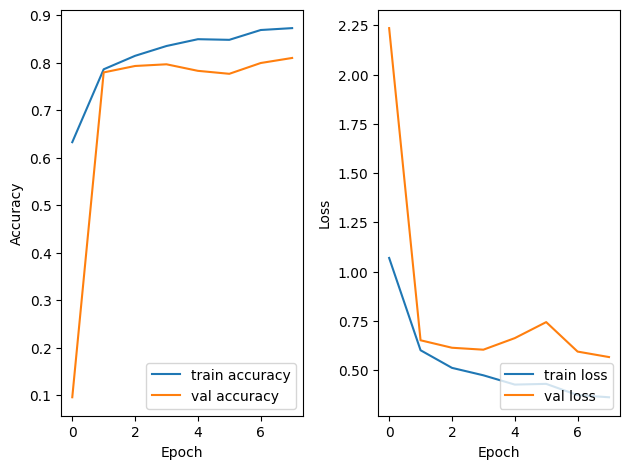

Test accuracy: 79.65%
Test loss: 0.598


100%|██████████| 118/118 [34:01<00:00, 17.30s/it]

Finished epoch 0 of 10: Train Loss = 0.347  Val Loss = 0.598   Train Acc = 0.878   Val Acc = 0.796



100%|██████████| 118/118 [33:48<00:00, 17.19s/it]

Finished epoch 1 of 10: Train Loss = 0.104  Val Loss = 0.452   Train Acc = 0.965   Val Acc = 0.861



100%|██████████| 118/118 [33:52<00:00, 17.23s/it]

Finished epoch 2 of 10: Train Loss = 0.036  Val Loss = 0.383   Train Acc = 0.993   Val Acc = 0.883



100%|██████████| 118/118 [33:37<00:00, 17.09s/it]

Finished epoch 3 of 10: Train Loss = 0.017  Val Loss = 0.321   Train Acc = 0.998   Val Acc = 0.910



100%|██████████| 118/118 [34:05<00:00, 17.33s/it]


Finished epoch 4 of 10: Train Loss = 0.011  Val Loss = 0.329   Train Acc = 0.998   Val Acc = 0.908


100%|██████████| 118/118 [33:53<00:00, 17.23s/it]

Finished epoch 5 of 10: Train Loss = 0.008  Val Loss = 0.297   Train Acc = 1.000   Val Acc = 0.905



100%|██████████| 118/118 [34:03<00:00, 17.32s/it]

Finished epoch 6 of 10: Train Loss = 0.006  Val Loss = 0.295   Train Acc = 1.000   Val Acc = 0.919



100%|██████████| 118/118 [33:50<00:00, 17.21s/it]

Finished epoch 7 of 10: Train Loss = 0.004  Val Loss = 0.303   Train Acc = 1.000   Val Acc = 0.914



100%|██████████| 118/118 [34:07<00:00, 17.35s/it]

Finished epoch 8 of 10: Train Loss = 0.005  Val Loss = 0.296   Train Acc = 1.000   Val Acc = 0.915



100%|██████████| 118/118 [34:26<00:00, 17.52s/it]


Finished epoch 9 of 10: Train Loss = 0.004  Val Loss = 0.291   Train Acc = 1.000   Val Acc = 0.914


100%|██████████| 15/15 [04:06<00:00, 16.45s/it]


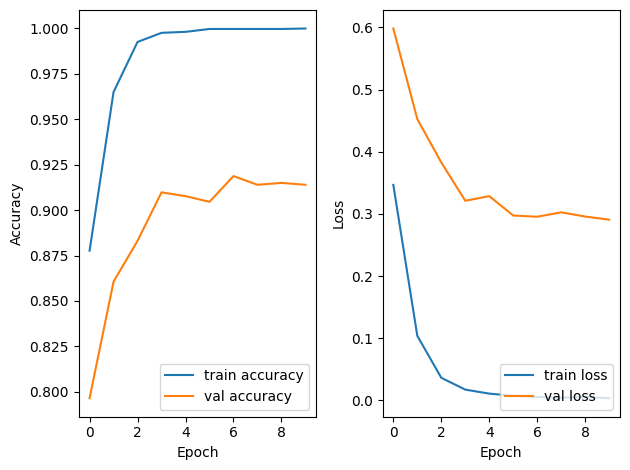

Test accuracy: 91.54%
Test loss: 0.291
Confusion Matrix:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0  83   0   0   0   1   0   3   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [25]:
# densenet121
pipeline(models.densenet121(pretrained=True))

In [ ]:
# densenet121 (debugging)
dn = pipeline(models.densenet121(pretrained=True))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 66%|██████▌   | 78/118 [11:38<06:01,  9.03s/it]